<a href="https://colab.research.google.com/github/ConnieNCSU/Manufacturing_Service_Text_Classification_by_fine_tuning_BERT/blob/main/Manufacturing_Service_Text_Classification_by_fine_tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Binary Text Classification Using BERT-Fine-Tuning (Manufacturing Service Textual Data Analysis)**

**Reference**: https://pysnacks.com/bert-text-classification-with-fine-tuning

In [2]:
#@title Install libraries
!pip install -q keras-bert keras-rectified-adam
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#!pip install h5py==2.10.0


In [23]:
import tensorflow.compat.v1 as tf

In [35]:
#@title Set environment variables
import os
import contextlib
#import tensorflow as tf
import tensorflow.compat.v1 as tf
#import tensorflow.keras as keras

USE_TPU = False
os.environ['TF_KERAS'] = '1'

# @title Initialize TPU Strategy
if USE_TPU:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)

import os
import codecs
import numpy as np
from tqdm import tqdm

# Tensorflow Imports
#import tensorflow as tf
from tensorflow.compat.v1 import keras

#import tensorflow.keras.backend as K
import tensorflow.compat.v1.keras.backend as K

# Keras-bert imports
from keras_radam import RAdam
from keras_bert import Tokenizer
from keras_bert import get_custom_objects
from keras_bert import load_trained_model_from_checkpoint

os.environ['TF_KERAS'] = '1'

# Bert Model Constants
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')


### Import Manufacuturing Service Textual Labeled Data. 
The text contents related to manufacturing service are labeled as 1. The others are labeled as 0.

In [36]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive/')
df=pd.read_csv('/content/gdrive/My Drive/2022 spring/service_train_data0211.csv')
df.round()
df.head()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


,comment_text,Service&Machine
0,design and build cnc machining,1
1,serves sheet metal asme welding,1
2,build cnc machining electromechanical assembly,1
3,specialists in cnc wire forming,1
4,to anodizing to laser engraving,1


In [37]:
# @title Prepare training and test data

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict)

def load_data(path, tagset):
    """
    Input:
      path: Root directory where the categorical data sit in folders.
      tagset: List of folder-name, category tuples.
    Output:
      train_x / test_x: List with two items (viz token_input, seg_input)
      test_x / test_y: Output labels corresponding to trainx / train_y.
    """
    global tokenizer
    indices, sentiments = [], []
    for folder, sentiment in tagset:
        folder = os.path.join(path, folder)
        for name in tqdm(os.listdir(folder)):
            with open(os.path.join(folder, name), 'r') as reader:
                  text = reader.read()
            ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
            indices.append(ids)
            sentiments.append(sentiment)
  
    items = list(zip(indices, sentiments))
    np.random.shuffle(items)
    indices, sentiments = zip(*items)
    indices = np.array(indices)
    mod = indices.shape[0] % BATCH_SIZE
    if mod > 0:
        indices, sentiments = indices[:-mod], sentiments[:-mod]
    return [indices, np.zeros_like(indices)], np.array(sentiments)
  
  


### create an attention mask in fine-tuning BERT:

Initialize an array of zeros with the same length as the input tokens.
For each token, if it is a real token, change the corresponding value in the attention mask array to 1.
Convert the attention mask array to a tensor, so it can be used as an input to the BERT model.


In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
df_shuffled=shuffle(df)
train_df=df_shuffled
indice=[]
for item in train_df['comment_text']:
    id,sege=tokenizer.encode(str(item),max_len=SEQ_LEN)
    indice.append(id)

train_x,train_y=[np.array(indice),np.zeros_like(indice)],np.array(train_df['Service&Machine'])
len(train_x[0])


#np.array(df['Service&Machine'])

13370

In [39]:
test_df=pd.read_csv('/content/gdrive/My Drive/2022 spring/service_test_data0211.csv')
test_df.round()
test_df=shuffle(test_df)

In [40]:
indice=[]
for item in test_df['comment_text']:
  id,sege=tokenizer.encode(str(item),max_len=SEQ_LEN)
  indice.append(id)

test_x,test_y=[np.array(indice),np.zeros_like(indice)],np.array(test_df['Service&Machine'])

In [41]:
# @title Build Fine-Tuned Bert model

# Load pretrained model
with strategy.scope() if USE_TPU else contextlib.suppress():
  model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      training=True,
      trainable=True,
      seq_len=SEQ_LEN,
  )
  inputs = model.inputs[:2]
  dense = model.get_layer('NSP-Dense').output
  outputs = keras.layers.Dense(units=2, activation='softmax')(dense)
  model = keras.models.Model(inputs, outputs)

  model.compile(
      RAdam(lr=LR),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'],
  )

print (model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 128, 768),  23440896    ['Input-Token[0][0]']            
 g)                              (30522, 768)]                                                    
                                                                                                  
 Embedding-Segment (Embedding)  (None, 128, 768)     1536        ['Input-Segment[0][0]']    

/usr/local/lib/python3.8/dist-packages/keras_radam/optimizer_v2.py:59: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RAdam, self).__init__(name, **kwargs)


                                                                  'Encoder-5-FeedForward-Dropout[0
                                                                 ][0]']                           
                                                                                                  
 Encoder-5-FeedForward-Norm (La  (None, 128, 768)    1536        ['Encoder-5-FeedForward-Add[0][0]
 yerNormalization)                                               ']                               
                                                                                                  
 Encoder-6-MultiHeadSelfAttenti  (None, 128, 768)    2362368     ['Encoder-5-FeedForward-Norm[0][0
 on (MultiHeadAttention)                                         ]']                              
                                                                                                  
 Encoder-6-MultiHeadSelfAttenti  (None, 128, 768)    0           ['Encoder-6-MultiHeadSelfAttentio
 on-Dropou

In [45]:
# @title Train
history = model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.20,
    shuffle=True,
)
#model.save('updated_imdb_sa.h5')

Epoch 1/3
669/669 [==============================] - 403s 531ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.0235 - val_sparse_categorical_accuracy: 0.9929
Epoch 2/3
669/669 [==============================] - 353s 528ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9921
Epoch 3/3
669/669 [==============================] - 354s 529ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0193 - val_sparse_categorical_accuracy: 0.9936


In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/2022 spring/serviceClassification.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/2022 spring/serviceClassification.h5")
#model.save("/content/gdrive/My Drive/2022 spring/serviceClassification1.h5")

In [ ]:
model.save("/content/gdrive/My Drive/2022 spring/serviceClassification1.h5")

In [43]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
from keras.models import load_model
 

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


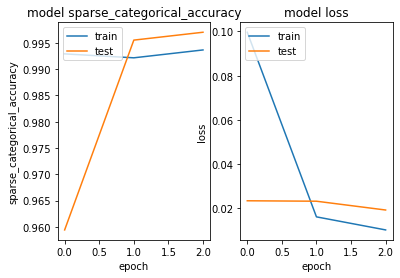

In [47]:
#@title Plot model training progress
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
#@title Get test set predictions.
predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

7/7 [==============================] - 6s 247ms/step


In [49]:
#@title Evaluate Model Accuracy and F1 Score
! pip install -q scikit-plot
import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(test_y, predicts)
macro_f1 = f1_score(test_y, predicts, average='macro')
micro_f1 = f1_score(test_y, predicts, average='micro')
weighted_f1 = f1_score(test_y, predicts, average='weighted')

print("Accuracy: %s" % accuracy)
print ('macro_f1: %s\nmicro_f1:%s\nweighted_f1:%s' %(
    macro_f1, micro_f1, weighted_f1)
)

#skplt.metrics.plot_confusion_matrix(
    #[id_to_labels[x] for x in test_y], 
    #[id_to_labels[x] for x in predicts],
    #figsize=(10,10))

Accuracy: 0.905
macro_f1: 0.9034920634920633
micro_f1:0.905
weighted_f1:0.9042158730158729


In [52]:
#@title Classifying texts
texts = [
  "medical industry",
  "3144 Avent Ferry Rd, Raleigh, NC",
  'stainless steels',
  'ISO 9001',
  'Just wow!',
  'CNC Milling',
  'machine',
  'additive manufacturing',
  'The production units laser cutting and CNC bending facilities, a load testing building, and four shops dedicated to metal fabrication, plasma cutting, welding, plate rolling and forming for all types of metal'
]
for text in texts:
  ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
  inpu = np.array(ids).reshape([1, SEQ_LEN])
  predicted_id = model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0]
  print ("%s: %s"% (predicted_id, text))


1/1 [==============================] - 0s 40ms/step
0: medical industry
1/1 [==============================] - 0s 39ms/step
0: 3144 Avent Ferry Rd, Raleigh, NC
1/1 [==============================] - 0s 41ms/step
0: stainless steels
1/1 [==============================] - 0s 43ms/step
0: ISO 9001
1/1 [==============================] - 0s 40ms/step
0: Just wow!
1/1 [==============================] - 0s 40ms/step
1: CNC Milling
1/1 [==============================] - 0s 43ms/step
0: machine
1/1 [==============================] - 0s 49ms/step
1: additive manufacturing
1/1 [==============================] - 0s 42ms/step
1: The production units laser cutting and CNC bending facilities, a load testing building, and four shops dedicated to metal fabrication, plasma cutting, welding, plate rolling and forming for all types of metal
